# H₃⁺ — Noiseless VQE with Singles, Doubles, and UCCSD

This notebook performs **noiseless VQE** for the trihydrogen cation H₃⁺ using:
- UCC **singles**  
- UCC **doubles**  
- UCC **singles + doubles (UCCSD)**  

For each excitation class, we:
- Run VQE with Adam  
- Record convergence  
- Extract the final statevector  

This provides a clean baseline for all later noisy and mapping comparisons.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import sys, os, json

# Local package imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    ensure_dirs,
    build_run_filename,
)

ensure_dirs()

In [2]:
# Reproducibility
seed = 0
set_seed(seed)

# Molecule: H₃⁺ (equilateral triangle approximation)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [ 0.000000,  1.000000, 0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000],
])
basis = "STO-3G"
charge = +1

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=charge, basis=basis
)

electrons = 2
hf = qchem.hf_state(electrons, qubits)
num_wires = qubits

print(f"Qubits required: {qubits}")
print("HF state =", "|" + "".join(str(x) for x in hf) + "⟩")

Qubits required: 6
HF state = |110000⟩


In [3]:
# Excitation operators (singles and doubles)
from pennylane.qchem import excitations

singles, doubles = excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]

In [4]:
# Make a cost function for each excitation type
dev = qml.device("default.qubit", wires=num_wires)

def make_cost_fn(excitation_type):
    @qml.qnode(dev)
    def cost_fn(params):
        if excitation_type == "single":
            selected = (singles, [])
        elif excitation_type == "double":
            selected = ([], doubles)
        else:
            selected = (singles, doubles)

        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected,
            excitation_type=excitation_type,
        )
        return qml.expval(hamiltonian)
    return cost_fn

In [5]:
# Cache-aware VQE wrapper
def run_vqe_for(excitation_type, stepsize, max_iterations):

    if excitation_type == "single":
        n_params = len(singles)
        desc = "UCC Singles"
    elif excitation_type == "double":
        n_params = len(doubles)
        desc = "UCC Doubles"
    else:
        n_params = len(singles) + len(doubles)
        desc = "UCCSD"

    cost_fn = make_cost_fn(excitation_type)

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=desc,
        optimizer_name="Adam",
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
    )
    cfg["excitation_type"] = excitation_type

    sig = run_signature(cfg)
    fname = build_run_filename(f"H3plus_Noiseless_{excitation_type}", "Adam", seed, sig)
    existing = find_existing_run(sig)

    # Load cached run
    if existing:
        print(f"[reuse] {excitation_type}: {existing}")
        with open(existing) as f:
            rec = json.load(f)
        return {
            "energies": rec["energies"],
            "params": np.array(rec["final_params"])
        }

    # Fresh run
    params = np.zeros(n_params, requires_grad=True)
    opt = get_optimizer("Adam", stepsize=stepsize)

    energies = [cost_fn(params)]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(e_prev)

    energies[-1] = float(cost_fn(params))

    record = {
        "config": cfg,
        "energies": [float(x) for x in energies],
        "final_params": [float(x) for x in params],
        "timestamp": __import__("time").strftime("%Y-%m-%d %H:%M:%S"),
    }
    save_run_record(fname, record)

    return {"energies": energies, "params": params}

In [6]:
# Run VQE for all excitation types
stepsize = 0.2
max_iterations = 50

excitation_types = ["single", "double", "both"]
results = {}

for exc in excitation_types:
    print(f"\n> Running VQE for: {exc}")
    results[exc] = run_vqe_for(exc, stepsize, max_iterations)


> Running VQE for: single
[reuse] single: /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Noiseless_single_Adam_s0__a40e5e6487a8.json

> Running VQE for: double
[reuse] double: /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Noiseless_double_Adam_s0__9d2017748fe2.json

> Running VQE for: both


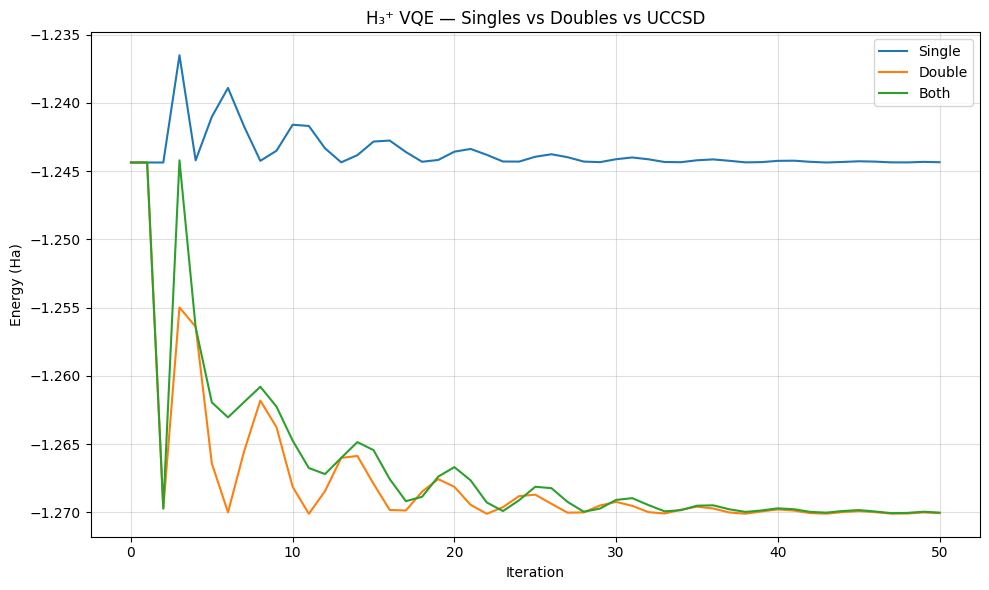

In [7]:
# Plot convergence
plt.figure(figsize=(10, 6))
for exc in excitation_types:
    plt.plot(results[exc]["energies"], label=exc.capitalize())

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — Singles vs Doubles vs UCCSD")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, "H3plus_Excitation_Comparison.png"), dpi=300)
plt.show()


--------------------------------------------------------------------------------
State decomposition for: single
 |ψ⟩ = 1.0000|110000⟩

--------------------------------------------------------------------------------
State decomposition for: double
 |ψ⟩ = -0.0849|000011⟩ + -0.0848|001100⟩ + 0.9928|110000⟩

--------------------------------------------------------------------------------
State decomposition for: both
 |ψ⟩ = -0.0883|000011⟩ + -0.0821|001100⟩ + 0.9927|110000⟩


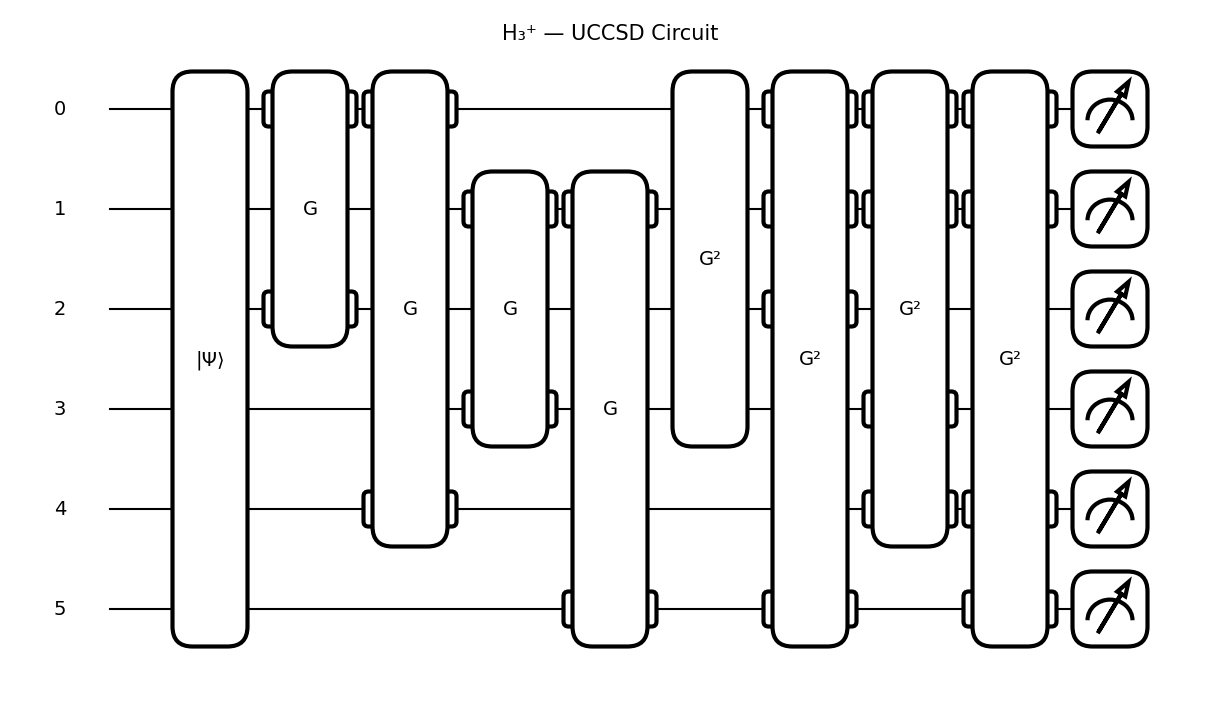

In [8]:
# Extract final statevectors and format them in ket notation
def make_state_qnode(excitation_type, selected_excitations):
    @qml.qnode(dev)
    def circuit(params):
        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_excitations,
            excitation_type=excitation_type,
        )
        return qml.state()
    return circuit

threshold = 1e-2

for exc in excitation_types:
    print("\n" + "-"*80)
    print(f"State decomposition for: {exc}")

    params = results[exc]["params"]

    if exc == "single":
        selected = (singles, [])
    elif exc == "double":
        selected = ([], doubles)
    else:
        selected = (singles, doubles)

    state_fn = make_state_qnode(exc, selected)
    psi = state_fn(params)

    nz = np.where(np.abs(psi) > threshold)[0]

    ket_terms = []
    for idx in nz:
        amp = psi[idx]
        bit = f"|{idx:0{num_wires}b}⟩"
        amp_str = f"{amp.real:.4f}" if abs(amp.imag) < 1e-6 else f"({amp.real:.4f} + {amp.imag:.4f}j)"
        ket_terms.append(f"{amp_str}{bit}")

    print(" |ψ⟩ =", " + ".join(ket_terms))

    # Draw circuit only for UCCSD
    if exc == "both":
        fig, ax = qml.draw_mpl(state_fn)(params)
        fig.suptitle("H₃⁺ — UCCSD Circuit", fontsize=15)
        fig.savefig(os.path.join(IMG_DIR, "H3plus_UCCSD_Circuit.png"), dpi=300)
        plt.show()